In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import subprocess as sp
import itertools as it

In [14]:
def genData(procs, sizes, data_file, cycles=20, clean=False):
    sp.run(
        "/usr/bin/mpiCC -O2 -o 15-matrix-matrix-blas.o ./10-matrix-matrix-blas.cpp -lblas",
        shell=True,
        stdout=sp.DEVNULL,
        stderr=sp.DEVNULL
    )
    if clean:
        sp.run(
            f'echo "num_rows1 num_rowscols12 num_cols2 num_procs avg_time total_time" > {data_file}',
            shell=True,
            stdout=sp.DEVNULL,
            stderr=sp.DEVNULL
        )

    for size, proc in it.product(sizes, procs):
        for _ in range(cycles):
            sp.run(
                f"/usr/bin/mpirun -n {proc} ./15-matrix-matrix-blas.o 0 {size} {size} {size}",
                shell=True,
                stdout=sp.DEVNULL,
                stderr=sp.DEVNULL
            )
        print(f"Finished ({size}x{size}).({size}x{size}) with {proc} processes")
        
def plotModel(
    data: pd.DataFrame,
    xdata: str,
    ydata: str,
    plot: bool,
    loglog: bool
):
    x = data[xdata].values.reshape(-1, 1)
    y = data[ydata].values.reshape(-1, 1)
    xname = xdata
    yname = ydata
    if loglog:
        x = np.log10(x)
        y = np.log10(y)
        xname = "log(" + xdata + ")"
        yname = "log(" + ydata + ")"

    linear_model = LinearRegression()
    linear_model.fit(x, y)
    model = linear_model.predict(x)

    if plot:
        fig, ax = plt.subplots(figsize=(12,8))
        ax.set_title("Model: y = {:.6f}x + {:.6f}".format(linear_model.coef_[0][0], linear_model.intercept_[0]), size=24)
        ax.set_xlabel(xname, size=20)
        ax.tick_params(axis='x', labelsize=16)
        ax.set_ylabel(yname, size=20)
        ax.tick_params(axis='y', labelsize=16)
        ax.scatter(x, y)
        ax.plot(x, model, color='red')
        plt.show()
    
    return linear_model

In [15]:
# Variables
# data_file = "/home/jared/Desktop/mmblas-timings.txt"
data_file = "./mmblas-timings.txt"
procs = np.array([3, 4, 5, 6, 7, 8])
sizes = np.array([10, 50, 100, 250, 500, 1000, 2000, 3000])

# Generate data if needed
# genData(procs=procs, sizes=sizes, cycles=5, data_file=data_file, clean=True)

# Load the data
data = pd.read_csv(data_file, delimiter=" ")

In [16]:
num_procs = 4
num_rows = 2000
min_procs = 2
min_rows = 100

data_reduced_row_scaling = data[data["num_procs"] == num_procs]
data_reduced_row_scaling = data_reduced_row_scaling[data_reduced_row_scaling["num_rows1"] > min_rows]

data_reduced_proc_scaling = data[data["num_rows1"] == num_rows]
data_reduced_proc_scaling = data_reduced_proc_scaling[data_reduced_proc_scaling["num_procs"] > min_procs]

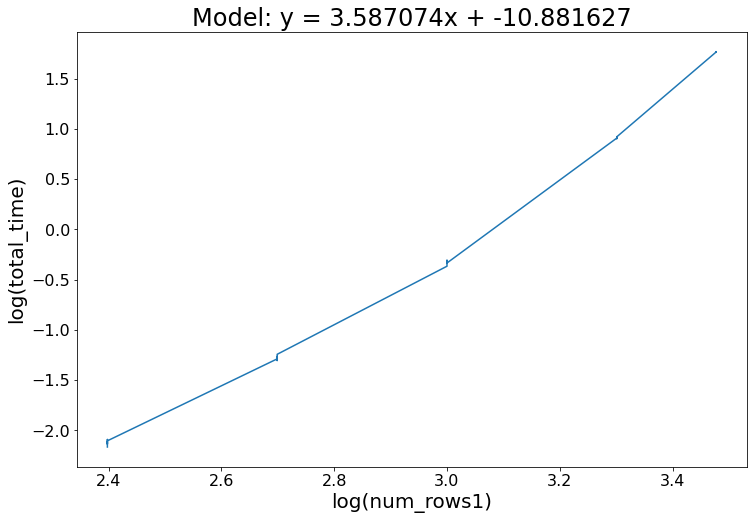

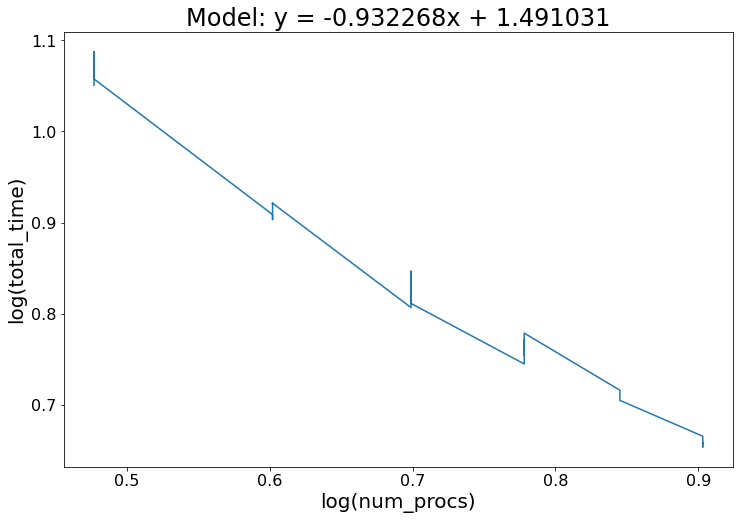

In [17]:
reduced_row_scaling_model = plotModel(data_reduced_row_scaling, "num_rows1", "total_time", plot=True, loglog=True)
reduced_proc_scaling_model = plotModel(data_reduced_proc_scaling, "num_procs", "total_time", plot=True, loglog=True)

In [18]:
serial_times = {
    10: 0.0000098080,
    50: 0.0000766340,
    100: 0.0006722290,
    250: 0.0113088620,
    500: 0.1293852690,
    1000: 0.9592790570,
    2000: 12.9402246380,
    3000: 152.6979877890
}

prediction = np.array([
    10**val[0] for val in
    reduced_proc_scaling_model.predict(np.log10(procs.reshape(-1, 1)))
])

speedup = serial_times[num_rows] / (prediction)
print("speedup = \n", np.array_str(speedup))

a = speedup / procs
print("a = \n", np.array_str(a))

efficiency = speedup / procs
print("efficiency = \n", np.array_str(efficiency))

speedup = 
 [1.16336467 1.52122102 1.87300299 2.22001879 2.56312056 2.90290684]
a = 
 [0.38778822 0.38030525 0.3746006  0.37000313 0.36616008 0.36286336]
efficiency = 
 [0.38778822 0.38030525 0.3746006  0.37000313 0.36616008 0.36286336]
